### Imports

In [54]:
import json
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import corner
from astropy import constants as const
from gwpy.timeseries import TimeSeries
from pycbc.detector import Detector
import bilby
from pesummary.io import read
from math import pi
import h5py
from scipy.interpolate import InterpolatedUnivariateSpline


# Plot parameters
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['axes.labelsize'] = 24
matplotlib.rcParams['xtick.labelsize'] = 30
matplotlib.rcParams['ytick.labelsize'] = 30
matplotlib.rcParams['xtick.major.size'] = 20
matplotlib.rcParams['ytick.major.size'] = 20
matplotlib.rcParams['xtick.top'] = True
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['xtick.minor.visible'] = True
matplotlib.rcParams['xtick.minor.size'] = 10
matplotlib.rcParams['ytick.minor.size'] = 10
matplotlib.rcParams['legend.fontsize'] = 18
matplotlib.rcParams['legend.frameon'] = True
matplotlib.rcParams['lines.linewidth'] = 3

### Helper functions

In [55]:
def GetPeakTime(time, data): 
    """ Grab the peak time of some data """
    t_peak = time[np.argmax(data)]
    return t_peak

def SubtractPeakTime(time, data): 
    """ Subtract the peak time of some data """
    t_peak = GetPeakTime(time, data)
    return time - t_peak
    
def dt_eval(time):
    """ Return the time step of a given time array """
    return (time[1] - time[0])

def swsh(s, modes, theta, phi, psi=0):
    """
    Return a value of a spin-weighted spherical harmonic of spin-weight s. 
    If passed a list of several modes, then a numpy array is returned with 
    SWSH values of each mode for the given point.
    For one mode:       swsh(s,[(l,m)],theta,phi,psi=0)
    For several modes:  swsh(s,[(l1,m1),(l2,m2),(l3,m3),...],theta,phi,psi=0)
    """
    import spherical_functions as sf
    import quaternion as qt
    return sf.SWSH(qt.from_spherical_coords(theta, phi), s, modes) * np.exp(1j * s * psi)

## Helper functions
def Ramp(time, t_s, t_r):
    """ Ramp function for tapering the waveform"""
    if (time < t_s):
        return 0.0
    elif time > (t_s + t_r):
        return 1.0
    else:
        t = (time - t_s)/t_r
        return t**5*(126 + t*(-420 + t*(540 + t*(-315 + 70*t))))

### Grab waveform from frames files

In [56]:
def GetFramesData(p, det = 'H1'):
    
    sH = TimeSeries.read(source = p + '/Frames/' + det + '.gwf', channel=det+":LDAS_STRAIN")
    tH = np.array(sH.times)
    return tH, sH

### Grab injected parameters (for surrogate)

In [57]:
def GetInjectedParameters(p):
    """ Return a dictionary of values from the parameters.json file 
        corresponding to the frames, where p is the path to the file """
    
    f = open(p + '/parameters.json')
    params = json.load(f)
    f.close()
    return params

### Get Bilby parameters

In [58]:
def GetBilbyParameters(p):

    result = bilby.core.result.read_in_result(p + "/outdir/fast_tutorial_result.json")
    maxL_ind = np.argmax(result.posterior['log_likelihood'])
    maxL_point = result.posterior.iloc[maxL_ind]
    maxP_ind = np.argmax(result.posterior['log_likelihood'] + result.posterior['log_prior'])
    maxP_point = result.posterior.iloc[maxP_ind]
    
    return maxP_point

def GetBilbyDict(BilbyRes):
    
    BilbyDict = {} ##maxL_point
    print(BilbyRes)
    BilbyDict['q'] = 1.0/BilbyRes['mass_ratio']
    BilbyDict['dt'] = 1.0/2048.
    q = BilbyDict['q']
    BilbyDict['mass'] = BilbyRes['chirp_mass'] * (q/(1+q)**2)**(-3/5)
    BilbyDict['dist_mpc'] = BilbyRes['luminosity_distance'] 
    BilbyDict['f_low'] = 0.0
    BilbyDict['theta'] = BilbyRes['theta_jn']
    BilbyDict['phi'] = BilbyRes['phase'] ## Is this right?
    a_1 = BilbyRes['a_1']
    a_2 = BilbyRes['a_2']
    BilbyDict['a_1'] = [0, 0, a_1] ## Assume spin-aligned for now
    BilbyDict['a_2'] = [0, 0, -a_2] ## Assume spin anti-aligned for now
    BilbyDict['ra'] = BilbyRes['ra']
    BilbyDict['dec'] = BilbyRes['dec']
    BilbyDict['t_gps'] = BilbyRes['geocent_time']
    BilbyDict['pol'] = BilbyRes['psi'] ## Is this right?
    return BilbyDict
    
    

### Get Surrogate waveforms

#### Import surrogate

In [59]:
import gwsurrogate
sur = gwsurrogate.LoadSurrogate('NRSur7dq4')

/home/maria.okounkova/.local/lib/python3.6/site-packages/gwsurrogate/new/precessing_surrogate.py:245: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  self.t = h5file['t_ds'].value
/home/maria.okounkova/.local/lib/python3.6/site-packages/gwsurrogate/new/precessing_surrogate.py:272: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  'coefs': group['%s_coefs'%(key)].value,
/home/maria.okounkova/.local/lib/python3.6/site-packages/gwsurrogate/new/precessing_surrogate.py:273: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  'bfOrders': group['%s_bfOrders'%(key)].value
/home/maria.okounkova/.local/lib/python3.6/site-packages/gwsurrogate/new/precessing_surrogate.py:282: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  'coefs': group['%s_%d_coefs'%(key, i)].value,
/home/maria.okounkova/.local/lib/python3.6/site-packages/gwsurrogate/new/precessing_sur

Loaded NRSur7dq4 model


#### Evaluate Surrogate

In [73]:
## Surrogate evaluation
def EvaluateSurrogate(params_dict):
    """ Evaluate the surrogate waveform """
   
    """ Surrogate documentation: If inclination/phi_ref are specified, the complex strain (h =
             hplus -i hcross) evaluated at (inclination, pi/2 - phi_ref) on
             the sky of the reference frame is returned.

        In order to agree with NR convetions, need phi_ref = pi/2 - phi"""

    data = sur(params_dict['q'], params_dict['a_1'], params_dict['a_2'], \
               dt = params_dict['dt'], units = 'mks', M = params_dict['mass'], \
               dist_mpc = params_dict['dist_mpc'], f_low = params_dict['f_low'], \
               inclination = params_dict['theta'], ellMax = 4, \
               phi_ref = params_dict['phi'])
               #phi_ref = pi/2 - params_dict['phi']) 

    time = data[0]
    h_plus = np.real(data[1])
    h_cross = -1 * np.imag(data[1])

    ## Now subtract off the peak time (this makes the spine interpolation easier)
    amp = np.sqrt(h_plus**2 + h_cross**2)
    time = time - time[np.argmax(amp)]

    return time, h_plus, h_cross, np.sqrt(h_plus**2 + h_cross**2)


## Read in the extrapolated modes
def ReadExtrapolatedModes(file, params_dict, interpolate = True):

    ## Convert distance to kpc and mass into solar masses
    mass = params_dict['mass']
    dist_mpc = params_dict['dist_mpc']
    theta = params_dict['theta']
    phi = params_dict['phi'] 
    dt = params_dict['dt']
    dist_kpc = dist_mpc * 1000 * const.kpc
    mass_msun = mass * const.M_sun
    
    ## Read in the data
    f = h5py.File(file, 'r')
    
    ## grab the length of the waveform first
    data = f['Extrapolated_N2.dir']['Y_l2_m2.dat']
    time = np.array(data[:,0])
    
    h_plus = np.zeros(len(time))
    h_cross = np.zeros(len(time))

    modes = [(l,m) for l in range(2,5) for m in range(-l, l+1)]
    for mode in modes: 
        
        ## Grab the mode in question
        l = mode[0]
        m = mode[1]
        
        data = f['Extrapolated_N2.dir']['Y_l' + str(l) + '_m' + str(m) + '.dat']
        real = np.array(data[:,1])
        imag = np.array(data[:,2])
        coeff = real + 1j * imag
        
        ## Multiply by the corresponding spin-weighted spherical harmonic
        Ylm = swsh(-2, [(l,m)], theta=theta, phi=phi, psi=0) 
        h = coeff * Ylm 
        
        ## Add to our h_plus and h_cross computations
        h_plus = h_plus + np.real(h)
        h_cross = h_cross - np.imag(h) 
        
        
    ## Apply the astrophysical parameters
    time = time*mass_msun*const.G/(const.c**3)
    h_plus = h_plus*const.G*mass_msun/((const.c)**2*dist_kpc)
    h_cross = h_cross*const.G*mass_msun/((const.c)**2*dist_kpc)

    ## Taper the waveform and apply the ramp (need to start the waveform at zero for this)
    time = time - time[0]
    ramp = np.array([Ramp(t.value, 0.1, 0.3) for t in time])
    
    h_plus = h_plus * ramp
    h_cross = h_cross * ramp
    
    # Now subtract off the peak time (this makes the spine interpolation easier)
    amp = np.sqrt(h_plus**2 + h_cross**2)
    time = time - time[np.argmax(amp)]
    
    if not interpolate:
        print("Not performing the interpolation")
        return time, h_plus, h_cross
    
    ## Now build the interpolants 
    cs_plus = InterpolatedUnivariateSpline(time, h_plus)
    cs_cross = InterpolatedUnivariateSpline(time, h_cross)

    ## Now create an evenly-spaced time array and interpolate the data 
    time_cs = np.arange(time[0].value, time[-1].value, dt)

    h_plus_cs = cs_plus(time_cs) 
    h_cross_cs = cs_cross(time_cs) 
    
    ## Return these new interpolated values
    ##return time, h_plus, h_cross, np.sqrt(h_plus**2 + h_cross**2)
    return time_cs, h_plus_cs, h_cross_cs, np.sqrt(h_plus_cs**2 + h_cross_cs**2)


### Get BW reconstructed waveforms


In [9]:
def GetBWDir(p):
    return p + '/BayesWave/Run/trigtime_1126259462.000000000_0.0_0.0_0/'

def GetMedianData(p, det = 'H1'):
    """ Given a coupling constant value and an SNR, return the columns of the median waveform data """
    
    ## Grab Livingston data
    f = GetBWDir(p) + "post/signal/signal_median_time_domain_waveform_" + det + ".dat"
    time, d1, d2, d3, d4, d5 = np.loadtxt(f, comments="#",usecols=([0,1,2,3,4,5]),unpack=True)
    
    ## Subtract peak time
    time = SubtractPeakTime(time, d1)
    
    return time, d1 #, d2, d3, d4, d5

def GetInjectedData(p, det = 'H1'):

    f = GetBWDir(p) + 'post/whitened_data_' + det + '.dat'
    data = np.loadtxt(f)
    
    s_rate = 2048 # Hz
    dt = 1.0/s_rate
    time = np.array([dt * t for t in range(len(data))])
    
    time = SubtractPeakTime(time, data)
    return time, data

### Plot reconstructions

In [61]:
p = '/home/maria.okounkova/BeyondGRAnalysis/BilbyPE/Test_FullSearchNoTiltNoSkyLoc_35_0p99'

#BW_inj_time, BW_inj_strain = GetInjectedData(p)
#BW_rec_time, BW_rec_strain = GetMedianData(p)
#t_frame, data_frame = GetFramesData(p)
#BilbyParameters = GetBilbyParameters(p)
#bilby_dict = GetBilbyDict(BilbyParameters)
#truth_dict = GetInjectedParameters(p)

In [68]:
truth_dict

{'a_1': [0, 0, 0.329892752405],
 'a_2': [0, 0, -0.439940981499],
 'mass_ratio': 0.8188310079446952,
 'chirp_mass': 29.422167356249002,
 'dt': 0.00048828125,
 't_gps': 1126259462.0,
 'peak_time_in_segment': 8.0,
 'segment_length': 16.0,
 'dist_mpc': 405.7935217454469,
 'mass': 68.0,
 'q': 1.2212532137858916,
 'chiA': [0, 0, 0.329892752405],
 'chiB': [0, 0, -0.439940981499],
 'f_low': 0,
 'theta': 3.141592653589793,
 'phi': 0,
 'ra': 1.952318922,
 'dec': -1.26967171703,
 'pol': 0.824043851821,
 'source': 'Waveforms/Lev5/dCS_Strain_0p0.h5',
 'H_SNR': 75.0,
 'L_SNR': 57.84123272985948}

In [ ]:
params_dict = truth_dict
file = '/home/maria.okounkova/BeyondGRAnalysis/Waveforms/Lev5/dCS_Strain_0p0.h5'
time, h_plus, h_cross, amp = ReadExtrapolatedModes(file, params_dict, interpolate = True)

In [92]:
truth_dict['phi'] = -pi/4 - 0.0485
time_sur, h_plus_sur, h_cross_sur, amp_sur = EvaluateSurrogate(truth_dict)

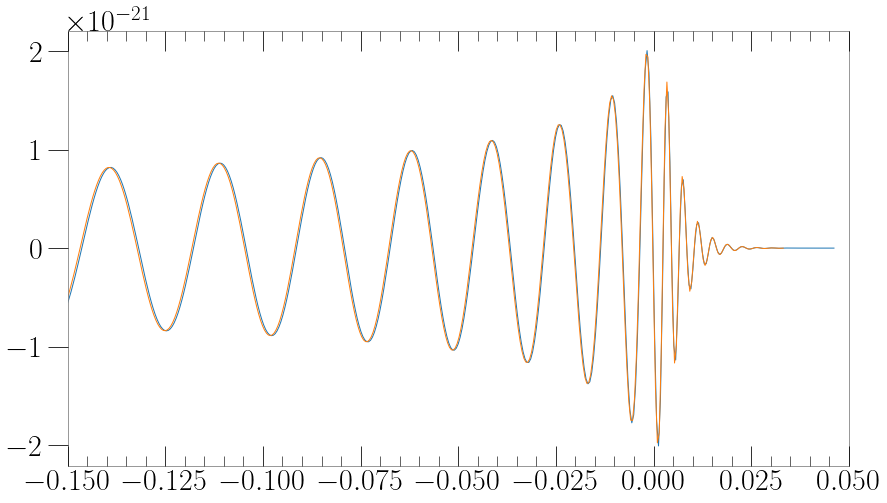

In [94]:
plt.figure(figsize=(14,8))
plt.plot(time, h_cross, lw = 1.0)
plt.plot(time_sur, h_cross_sur, lw = 1.0)
plt.grid()
plt.xlim(-0.15, 0.05)
plt.show()

In [ ]:
GetBilbyParameters(p)